# Using `quimb` within `jax`, `flax` and `optax`

`quimb` is designed (using [`autoray`](https://github.com/jcmgray/autoray)) to 
handle many different array backends, including [`jax`](https://github.com/google/jax). If you put `jax` arrays in your tensors, then `quimb` will dispatch all operations to `jax` functions, and moreover tensor network algorithms can then be traced through in order to compute gradients, and/or jit-compiled.

While quimb has its own optimizer interface (`TNOptimizer`) which uses `jax`
or other libraries within it to compute the gradients, it is also possible to instead use `quimb` *within other* optimization frameworks. Here we demonstrate this with:

* [`flax`](https://github.com/google/flax) - a library for designing machine learning 'models', which is also compatible with [`netket`](https://github.com/netket/netket) for example, and
* [`optax`](https://github.com/deepmind/optax) - an optimization library for `jax` which can itself be jit-compiled.

The resulting computation is then entirely jit-compiled, with `quimb` merely orchestrating the initial computational graph.

Here'll we do a simple 1D MERA optimization on the Heisenberg model:

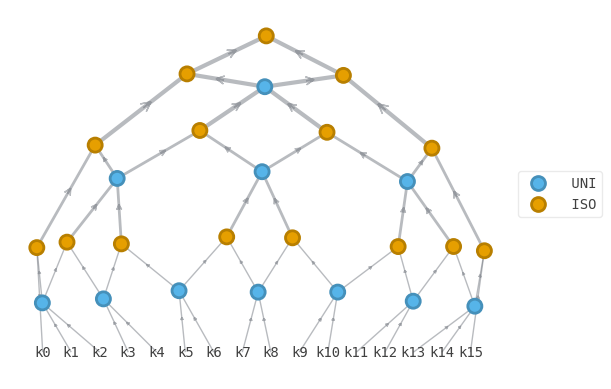

In [1]:
import quimb.tensor as qtn
from quimb.experimental.merabuilder import MERA

# our ansatz and hamiltonian
L = 16
psi = MERA.rand(L, D=8, seed=42, cyclic=False)
ham = qtn.ham_1d_heis(L)

psi.draw(
    color=['UNI', 'ISO'],
    fix={psi.site_ind(i): (i, 0) for i in range(L)},
)

As with `TNOptimizer`, we need a `loss_fn` which takes a tensor network and returns a scalar quantity to minimize. Often we also need a `norm_fn`, which first maps the tensor network into a constrained space (for example, with all unitary tensors):


In [2]:
def norm_fn(psi):
    # parametrize our tensors as isometric/unitary
    return psi.isometrize(method="cayley")

def loss_fn(psi):
    # compute the total energy, here quimb handles constructing 
    # and contracting all the appropriate lightcones 
    return psi.compute_local_expectation(ham)

In [3]:
# our initial energy:
loss_fn(norm_fn(psi))

-0.015578916803187806

Then we are ready to [construct our 'model' using `flax`](https://flax.readthedocs.io/en/latest/guides/setup_or_nncompact.html) (something very similar
can also be done [for e.g. `haiku` models](https://dm-haiku.readthedocs.io/en/latest/)): 

In [4]:
import jax
import flax.linen as nn
import optax

class CustomModule(nn.Module):

    def setup(self):
        # strip out the initial raw arrays
        params, skeleton = qtn.pack(psi)
        # save the stripped 'skeleton' tn for use later
        self.skeleton = skeleton

        # assign each array as a parameter to optimize
        self.params = {
            i: self.param(f'param_{i}', lambda _: data)
            for i, data in params.items()
        }

    def __call__(self):
        psi = qtn.unpack(self.params, self.skeleton)
        return loss_fn(norm_fn(psi))

Next we define a single, [jit-compiled, optimization step](https://optax.readthedocs.io/en/latest/optax-101.html):

In [5]:
# initialize our model and loss/gradient function
model = CustomModule()
params = model.init(jax.random.PRNGKey(42))
loss_grad_fn = jax.value_and_grad(model.apply)

# initialize our optimizer
tx = optax.adabelief(learning_rate=0.01)
opt_state = tx.init(params)

@jax.jit
def step(params, opt_state):
    # our step: compute the loss and gradient, and update the optimizer
    loss, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

And now we are ready to optimize!

In [6]:
import tqdm

its = 1_000
pbar = tqdm.tqdm(range(its))

for _ in pbar:
    params, opt_state, loss_val = step(params, opt_state)
    pbar.set_description(f"{loss_val}")

-6.904621124267578: 100%|██████████| 1000/1000 [00:33<00:00, 29.88it/s] 


Finally if we want to insert the optimized raw parameters back into a tensor network then we can do so with:

In [7]:
mera_opt = psi.copy()

# resinsert the raw, optimized arrays
for i, t in mera_opt.tensor_map.items():
    t.modify(data=params['params'][f'param_{i}'].__array__())

# then we want the constrained form
mera_opt = norm_fn(mera_opt)

Then we can check the energy outside of jax:

In [8]:
loss_fn(mera_opt)

-6.90447020410412

and that the state is still unitary and thus normalized:

In [9]:
mera_opt.H @ mera_opt

1.0000000242457867

## Notes

* `quimb` also registers all `Tensor` and `TensorNetwork` classes with jax's pytree system, so they can be used as directly input and output to functions such as `jax.grad` and `jax.jit`.
* `jax` by default converts everything to single precision (thus the deviation from 1.0 above), [see here about disabling this behavior](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision)